In [1]:
using DataFrames
using Underscores
using Pkg
using Chain
using Optim

using Plots
gr()

Plots.GRBackend()

In [2]:
abstract type Team end
struct Aligned <: Team end
struct Unaligned <: Team end

In [3]:
aligned = Aligned()
unaligned = Unaligned()

Unaligned()

In [4]:
world1 = 1
world2 = 2

2

In [5]:
worlds = [world1, world2]

2-element Array{Int64,1}:
 1
 2

In [6]:
teams = [aligned, unaligned]

2-element Array{Team,1}:
 Aligned()
 Unaligned()

In [7]:
function make_rows(teams, worlds, aligned_measure, starting_resources)
    rows = []
    for i in eachindex(teams), j in eachindex(worlds)
        team = teams[i]
        world = worlds[j]
        if world == worlds[1]
            measure = aligned_measure
        else
            measure = 1.0
        end
        if i == j
            resource = starting_resources
        else
            resource = 0.0
        end
        
        row = (team = team, world = world, measure = measure, resource = resource)
        push!(rows, row)
    end
    return rows
end
                


make_rows (generic function with 1 method)

In [8]:
test_data = DataFrame(make_rows(teams, worlds, .1, 10.0^22))

,team,world,measure,resource
,Team,Int64,Float64,Float64
1,Aligned(),1,0.1,1.0e22
2,Aligned(),2,1.0,0.0
3,Unaligned(),1,0.1,0.0
4,Unaligned(),2,1.0,1.0e22


In [9]:
# Utility functions

function get_utility(data; resource_col = "resource")
    return data.measure .* log10.(data[!, resource_col] .+ 1.0)
end


get_utility (generic function with 1 method)

In [10]:
test_data[!, "utility"] = get_utility(test_data)

4-element Array{Float64,1}:
  2.2
  0.0
  0.0
 22.0

In [11]:
test_data

,team,world,measure,resource,utility
,Team,Int64,Float64,Float64,Float64
1,Aligned(),1,0.1,1.0e22,2.2
2,Aligned(),2,1.0,0.0,0.0
3,Unaligned(),1,0.1,0.0,0.0
4,Unaligned(),2,1.0,1.0e22,22.0


In [12]:
""" data is a DataFrame containing (at least) world and resource columns
team_proportions is a DataFrame containing team, world, and proportion columns
"""
function get_proportional_resource_split(data::DataFrame, team_proportions::DataFrame)
    resources_by_world = @chain data begin
    groupby(_, :world)
    combine(_, :resource => sum => :total_world_resource)
    end
    
    joint_data = innerjoin(team_proportions, resources_by_world, on=:world, makeunique=true)
    joint_data[!, "resource_after_split"] = joint_data.total_world_resource .* joint_data.proportion
    
    return joint_data
end

function get_proportional_resource_split(data::DataFrame, team_proportions::Array)
    team_proportions_df = copy(data)
    team_proportions_df[!, "proportion"] = team_proportions
    return get_proportional_resource_split(data, team_proportions_df)
end

get_proportional_resource_split (generic function with 2 methods)

In [13]:
test_team_proportions = test_data[:, ["team", "world"]]
test_team_proportions[!, "proportion"] .= .5

4-element Array{Float64,1}:
 0.5
 0.5
 0.5
 0.5

In [14]:
get_proportional_resource_split(test_data, test_team_proportions)

,team,world,proportion,total_world_resource,resource_after_split
,Team,Int64,Float64,Float64,Float64
1,Aligned(),1,0.5,1.0e22,5.0e21
2,Aligned(),2,0.5,1.0e22,5.0e21
3,Unaligned(),1,0.5,1.0e22,5.0e21
4,Unaligned(),2,0.5,1.0e22,5.0e21


In [15]:
""" Calculate the Nash Bargaining Solution
per https://en.wikipedia.org/wiki/Cooperative_bargaining#The_Nash_bargaining_solution
The NBS is the source distribution that maximizes the product of each teams gains
relative to the utility they gain on disagreement
(u(x) - u(d))(v(x) - v(d))
"""
function NBS(data, utility_fn, disagreement_strategy; optimizer=NelderMead)
    
    """ Set up the function to be maximized
        as input, take team aligned's share of resources for each
        world. """

    
    """ Optimization libraries assume we're trying to minimize a functionrather than
    maximize, so we just multiply by -1"""
    function loss(aligned_resources) 
        return -1 * get_gains(aligned_resources, data, utility_fn, disagreement_strategy)
    end
    
    inner_optimizer = optimizer()
    results = optimize(loss, [0.0, 0.0], [1.0, 1.0], [0.5, 0.5], Fminbox(inner_optimizer), Optim.Options(time_limit = 2.0))
    return results
end
    
function get_gains(aligned_resources::Array, data, utility_fn, disagreement_strategy)
    gains_by_team = get_gains_df(aligned_resources, data, utility_fn, disagreement_strategy)

    objective = prod(gains_by_team.gains)
    return objective
end       

function get_gains_df(aligned_resources::Array, data, utility_fn, disagreement_strategy)
    unaligned_resources = 1.0 .- aligned_resources
    all_resources = vcat(aligned_resources, unaligned_resources)
    split_resources = get_proportional_resource_split(data, all_resources)
    proposed_utilities = utility_fn(split_resources, resource_col="resource_after_split")
    disagreement_utilities = disagreement_strategy(split_resources) 

    data[!, "gains"] .= proposed_utilities .- disagreement_utilities
    gains_by_team = @chain data begin 
        groupby(_, :team)
        combine(_, :gains => sum => :gains)
    end
    return gains_by_team
end   

get_gains_df (generic function with 1 method)

In [16]:
""" Calculate the Kalai-Smorodinsky Bargaining Solution
    per https://en.wikipedia.org/wiki/Kalai%E2%80%93Smorodinsky_bargaining_solution
    The KSBS maximizes the ratio of each team's gains relative to their maximum
    possible gain, subject to the constraint that each team receives the same ratio
    For example, if team aligned's maximum possible gain is 100, and team unaligned's maximum
    possible gain is 10, the KSBS solution might be for them to each gain 75% of their maximum,
    which would be 75 for team aligned and 7.5 for team unaligned
"""
function KSBS(data, utility_fn, disagreement_strategy; optimizer=NelderMead)
    function loss(aligned_resources) 
        gains_ratios = normalized_gains_df(aligned_resources, data, utility_fn, disagreement_strategy)
        a = gains_ratios.gains_ratio[1]
        b = gains_ratios.gains_ratio[2]
        # Want to maximize a, subject to the constraint that a == b
        return (-1 * a) + 100 * abs(a - b) 
    end
    
    inner_optimizer = optimizer()
    results = optimize(loss, [0.0, 0.0], [1.0, 1.0], [0.5, 0.5], Fminbox(inner_optimizer), Optim.Options(time_limit = 2.0))
    return results
end

function normalized_gains_df(aligned_resources::Array, data, utility_fn, disagreement_strategy)
    unaligned_resources = 1.0 .- aligned_resources
    all_resources = vcat(aligned_resources, unaligned_resources)
    split_resources = get_proportional_resource_split(data, all_resources)
    proposed_utilities = utility_fn(split_resources, resource_col="resource_after_split")
    disagreement_utilities = disagreement_strategy(split_resources) 
    maximum_utilities = utility_fn(get_proportional_resource_split(data, [1.0, 1.0, 1.0, 1.0]), resource_col="resource_after_split")
    
    data[!, "gains"] .= proposed_utilities .- disagreement_utilities
    data[!, "max_gains"] .= maximum_utilities .- disagreement_utilities
    gains_by_team = @chain data begin 
        groupby(_, :team)
        combine(_, :gains => sum => :gains, :max_gains => sum => :max_gains)
    end
    gains_by_team[!, "gains_ratio"] = gains_by_team.gains ./ gains_by_team.max_gains
    return gains_by_team
end   
    

normalized_gains_df (generic function with 1 method)

In [17]:
# Bargaining failure strategies

## By default, just stick to original utility
function standard_failure(data)
    return @chain data begin 
        get_utility(_, resource_col="resource")
    end
end

## Failure to bargain destroys all utility
zero_failure(data) = 0.0 

## When failing to bargain, subtract all other teams' utilities from ours
function conflict(data)
    opponent_utilities = @chain innerjoin(test_data, test_data, makeunique=true, on=:world) begin
    filter(row -> row.team != row.team_1, _)
    groupby([:team, :world])
    combine(:utility => maximum => :utility, :utility_1 => sum => :opponent_utility)
    end
    return opponent_utilities.utility .- opponent_utilities.opponent_utility
end

conflict (generic function with 1 method)

In [18]:
standard_failure(test_data)

4-element Array{Float64,1}:
  2.2
  0.0
  0.0
 22.0

In [19]:
conflict(test_data)

4-element Array{Float64,1}:
   2.2
 -22.0
  -2.2
  22.0

In [20]:
# Check world 2 utility
@chain test_data begin
    filter(:world => ==(world2), _)
    combine(_, :resource => sum => :resource, :measure => maximum => :measure)
    get_utility
end
    

1-element Array{Float64,1}:
 22.0

In [21]:
# Assigning all the resources in world 2 to team aligned should increase its
# utility by the above amount (since it starts at 0), and decrease
# team unaligned's utility by the same amount
normalized_gains_df([1.0, 1.00], test_data, get_utility, get_utility)

,team,gains,max_gains,gains_ratio
,Team,Float64,Float64,Float64
1,Aligned(),22.0,22.0,1.0
2,Unaligned(),-22.0,2.2,-10.0


In [22]:
@time test_NBS = NBS(test_data, get_utility, conflict; optimizer=NelderMead)

  2.691665 seconds (8.28 M allocations: 430.633 MiB, 5.69% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     -1.866086e+02

 * Found with
    Algorithm:     Fminbox with Nelder-Mead

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.22e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit 2)
    Iterations:    3
    f(x) calls:    175
    ∇f(x) calls:   1


In [23]:
@time test_KSBS = KSBS(test_data, get_utility, conflict)

  0.810508 seconds (3.68 M allocations: 274.782 MiB, 8.16% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     -9.804305e-01

 * Found with
    Algorithm:     Fminbox with Nelder-Mead

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.74e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit 2)
    Iterations:    11
    f(x) calls:    1968
    ∇f(x) calls:   1


In [24]:
test_KSBS.minimizer

2-element Array{Float64,1}:
 0.17448959606733486
 0.16396997724465182

In [25]:
test_KSBS.minimum

-0.9804304794066111

In [26]:
get_proportional_resource_split(test_data, vcat(test_NBS.minimizer, 1 .- test_NBS.minimizer))

,team,world,measure,resource,utility,gains,max_gains,proportion
,Team,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,Aligned(),1,0.1,1.0e22,2.2,-0.075823,0.0,0.0922137
2,Aligned(),2,1.0,0.0,0.0,43.2148,44.0,0.0922145
3,Unaligned(),1,0.1,0.0,0.0,4.39167,4.4,0.907786
4,Unaligned(),2,1.0,1.0e22,22.0,-0.0777781,0.0,0.907786


In [27]:
function probability_from_odds(odds)
    return odds / (odds + 1.0)
end

probability_from_odds (generic function with 1 method)

In [28]:
function odds_from_probability(probability)
    return probability / (1.0 - probability)
end

odds_from_probability (generic function with 1 method)

In [29]:
9 |> probability_from_odds

0.9

In [30]:
.9 |> odds_from_probability

9.000000000000002

In [31]:
function expected_utilities(data, utility_fn, bargaining_strategy, bargain_failure_utility, odds_bargaining_success)
    # Get expected utility grouped by team, based on the utility, bargaining strategy, and probability
    # that bargaining succeeds
    aligned_resource_bargained = bargaining_strategy(data, utility_fn, bargain_failure_utility).minimizer
    data_with_bargain_resources::DataFrame = get_proportional_resource_split(data, vcat(aligned_resource_bargained, 1 .- aligned_resource_bargained))
    bargain_success_utility = utility_fn(data_with_bargain_resources, resource_col="resource_after_split")
    bargain_fail_utility = bargain_failure_utility(data_with_bargain_resources)
    p = probability_from_odds(odds_bargaining_success)
    data_with_bargain_resources[!, "expected_utility"] = p .* bargain_success_utility .+ (1 - p) .* bargain_fail_utility
    return data_with_bargain_resources
end
    
    

expected_utilities (generic function with 1 method)

In [32]:
import Base.@kwdef

@kwdef struct ExperimentParameters
    teams::Array{Team}
    worlds::Array{Int}
    utility_fn::Function
    bargaining_strategy::Function
    bargain_failure_strategy::Function
    initial_resource::Float64
end

ExperimentParameters

In [33]:
baseline_parameters = ExperimentParameters(
    teams=teams,
    worlds=worlds,
    utility_fn=get_utility,
    bargaining_strategy=NBS,
    bargain_failure_strategy=standard_failure,
    initial_resource=1e22)

ExperimentParameters(Team[Aligned(), Unaligned()], [1, 2], get_utility, NBS, standard_failure, 1.0e22)

In [34]:
zero_failure_parameters = ExperimentParameters(
    teams=teams,
    worlds=worlds,
    utility_fn=get_utility,
    bargaining_strategy=NBS,
    bargain_failure_strategy=zero_failure,
    initial_resource=1e22)

ExperimentParameters(Team[Aligned(), Unaligned()], [1, 2], get_utility, NBS, zero_failure, 1.0e22)

In [35]:
conflict_parameters = ExperimentParameters(
    teams=teams,
    worlds=worlds,
    utility_fn=get_utility,
    bargaining_strategy=NBS,
    bargain_failure_strategy=zero_failure,
    initial_resource=1e22)

ExperimentParameters(Team[Aligned(), Unaligned()], [1, 2], get_utility, NBS, zero_failure, 1.0e22)

In [36]:
ksbs_parameters = ExperimentParameters(
    teams=teams,
    worlds=worlds,
    utility_fn=get_utility,
    bargaining_strategy=KSBS,
    bargain_failure_strategy=standard_failure,
    initial_resource=1e22)

ExperimentParameters(Team[Aligned(), Unaligned()], [1, 2], get_utility, KSBS, standard_failure, 1.0e22)

In [37]:
function aligned_utility(params::ExperimentParameters, odds_bargaining_success, aligned_measure)
    df = make_rows(params.teams, params.worlds, aligned_measure, params.initial_resource) |> DataFrame
    eu = expected_utilities(df, params.utility_fn, params.bargaining_strategy, params.bargain_failure_strategy, odds_bargaining_success)
    return @_ eu |> filter(_.team == aligned, __) |> sum(__.expected_utility)
end

aligned_utility (generic function with 1 method)

In [38]:
function aligned_gain_ratio(params::ExperimentParameters, odds, measure; step_size = 1.01)
    default = aligned_utility(params, odds, measure)
    gain_from_increased_measure = aligned_utility(params, odds, measure * step_size)
    gain_from_increased_bargaining = aligned_utility(params, odds * step_size, measure)
    
    return gain_from_increased_measure / gain_from_increased_bargaining 
end
    

aligned_gain_ratio (generic function with 1 method)

In [39]:
number_of_points = 25

25

In [40]:
measures = [10.0^n for n in LinRange(-3, 3, number_of_points)]

25-element Array{Float64,1}:
    0.001
    0.0017782794100389228
    0.0031622776601683794
    0.005623413251903491
    0.01
    0.01778279410038923
    0.03162277660168379
    0.05623413251903491
    0.1
    0.1778279410038923
    0.3162277660168381
    0.5623413251903487
    1.0
    1.7782794100389228
    3.1622776601683795
    5.623413251903491
   10.0
   17.78279410038923
   31.622776601683793
   56.23413251903491
  100.0
  177.82794100389228
  316.22776601683796
  562.341325190349
 1000.0

In [41]:
odds = [10.0^n for n in LinRange(-2, 2, number_of_points)]

25-element Array{Float64,1}:
   0.01
   0.01467799267622069
   0.021544346900318846
   0.03162277660168379
   0.046415888336127774
   0.06812920690579616
   0.1
   0.14677992676220702
   0.21544346900318828
   0.31622776601683794
   0.4641588833612781
   0.681292069057961
   1.0
   1.467799267622069
   2.1544346900318843
   3.1622776601683795
   4.6415888336127775
   6.812920690579615
  10.0
  14.67799267622069
  21.544346900318846
  31.622776601683793
  46.41588833612777
  68.12920690579615
 100.0

In [42]:
odds_and_measures = Base.product(odds, measures) |> collect

25×25 Array{Tuple{Float64,Float64},2}:
 (0.01, 0.001)       (0.01, 0.00177828)       …  (0.01, 1000.0)
 (0.014678, 0.001)   (0.014678, 0.00177828)      (0.014678, 1000.0)
 (0.0215443, 0.001)  (0.0215443, 0.00177828)     (0.0215443, 1000.0)
 (0.0316228, 0.001)  (0.0316228, 0.00177828)     (0.0316228, 1000.0)
 (0.0464159, 0.001)  (0.0464159, 0.00177828)     (0.0464159, 1000.0)
 (0.0681292, 0.001)  (0.0681292, 0.00177828)  …  (0.0681292, 1000.0)
 (0.1, 0.001)        (0.1, 0.00177828)           (0.1, 1000.0)
 (0.14678, 0.001)    (0.14678, 0.00177828)       (0.14678, 1000.0)
 (0.215443, 0.001)   (0.215443, 0.00177828)      (0.215443, 1000.0)
 (0.316228, 0.001)   (0.316228, 0.00177828)      (0.316228, 1000.0)
 (0.464159, 0.001)   (0.464159, 0.00177828)   …  (0.464159, 1000.0)
 (0.681292, 0.001)   (0.681292, 0.00177828)      (0.681292, 1000.0)
 (1.0, 0.001)        (1.0, 0.00177828)           (1.0, 1000.0)
 (1.4678, 0.001)     (1.4678, 0.00177828)        (1.4678, 1000.0)
 (2.15443, 0.001)    (

In [45]:
function show_graphs(params)
    utilities_grid = map(x -> aligned_utility(params, x...), odds_and_measures)
    gains_grid = map(x -> aligned_gain_ratio(params, x...), odds_and_measures)
    heatmap1 = heatmap(measures, odds, gains_grid, xaxis = :log, yaxis = :log, xlabel = "measure", ylabel = "odds", title = "Measure Gain Over Odds Gain")
    display(heatmap1)
    heatmap1_abs = heatmap(measures, odds, log10.(gains_grid), xaxis = :log, yaxis = :log, xlabel = "measure", ylabel = "odds", title = "Log (Measure Gain Over Odds Gain)")
    display(heatmap1_abs)
    heatmap2 = heatmap(measures, odds, utilities_grid, yaxis = :log10, xaxis = :log10, xlabel = "measure", ylabel = "odds", title = "Expected Utility")
    display(heatmap2)
    heatmap3 = heatmap(measures, odds, log10.(utilities_grid), yaxis = :log10, xaxis = :log10, xlabel = "measure", ylabel = "odds", title = "Expected Utility")
    display(heatmap3)
end

show_graphs (generic function with 1 method)

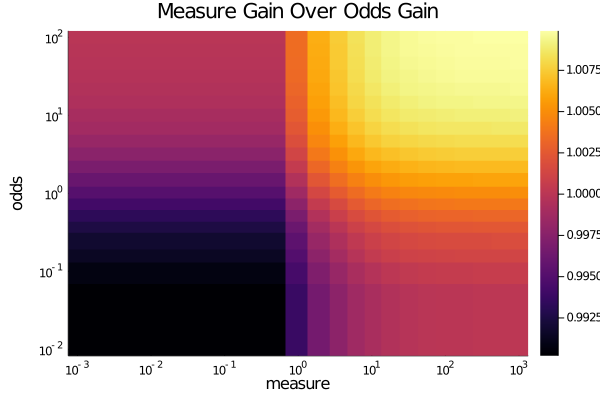

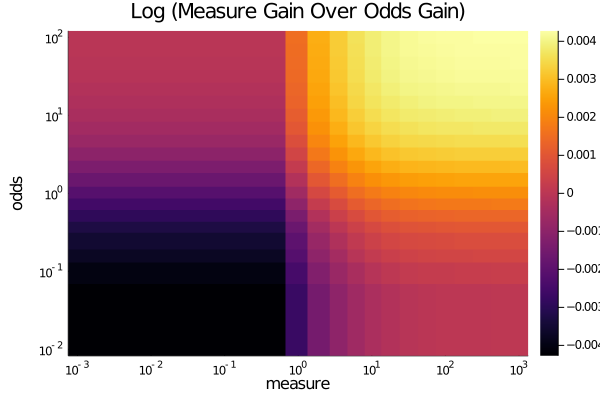

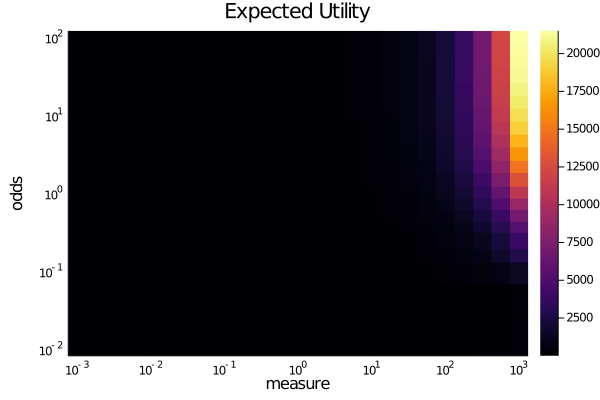

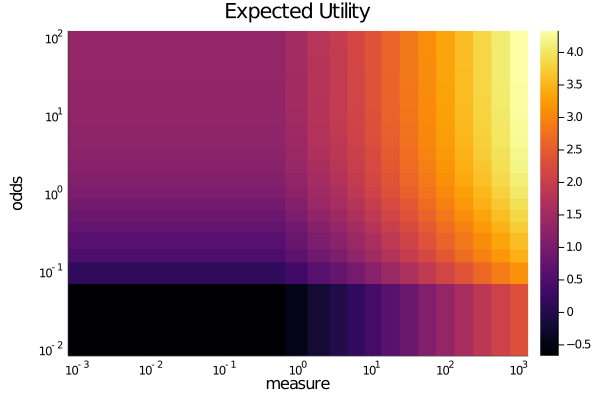

 19.739831 seconds (114.37 M allocations: 8.768 GiB, 8.54% gc time)


In [47]:
@time show_graphs(zero_failure_parameters)

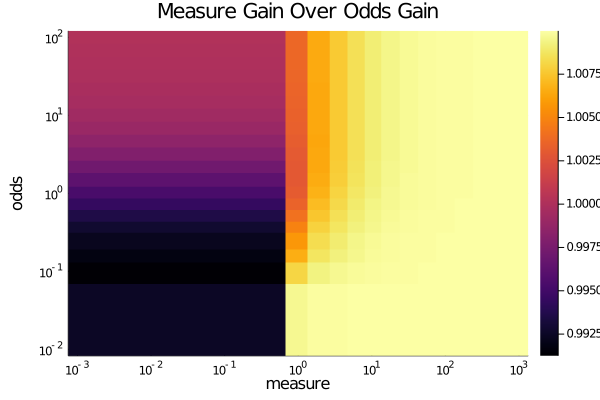

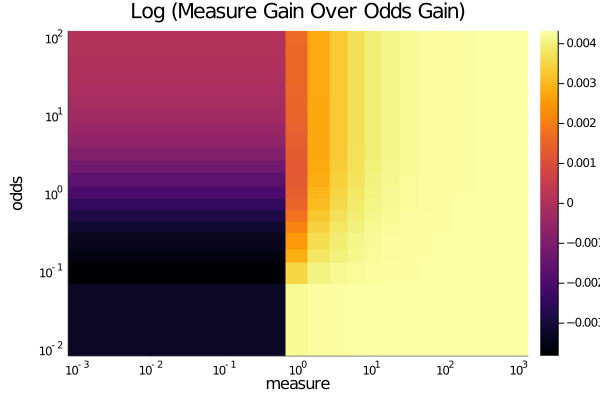

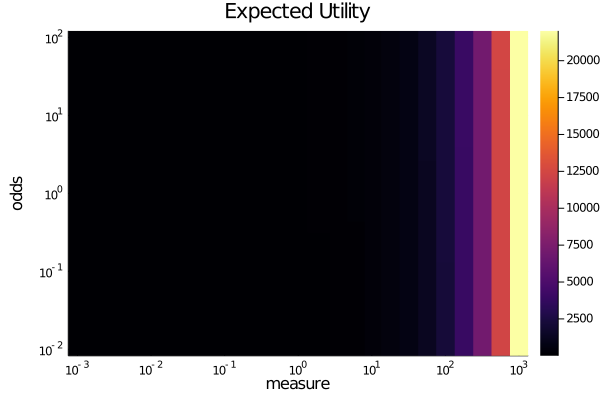

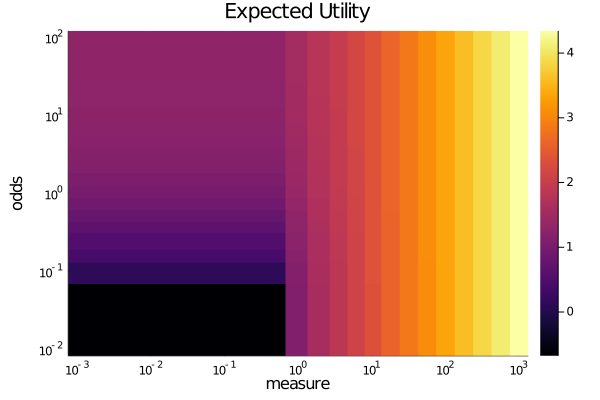

 71.506629 seconds (430.33 M allocations: 32.792 GiB, 8.68% gc time)


In [48]:
@time show_graphs(baseline_parameters)

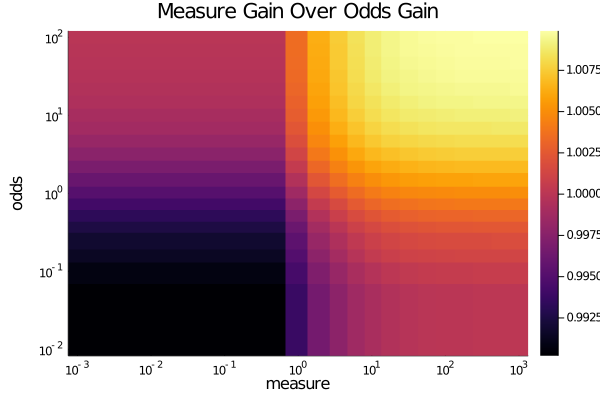

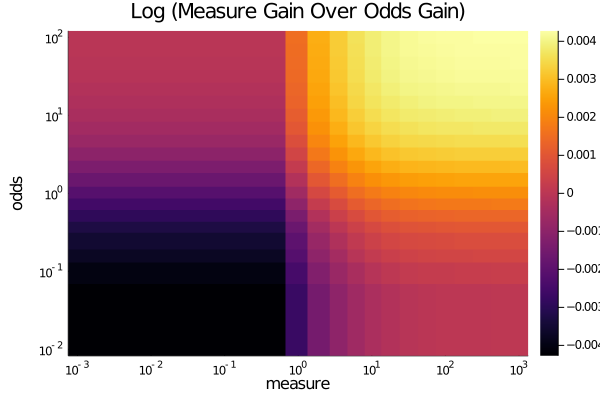

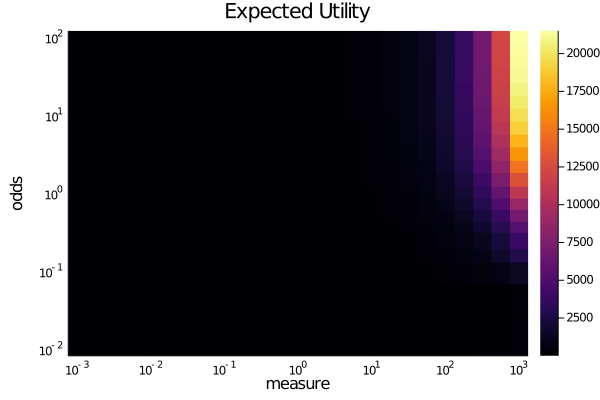

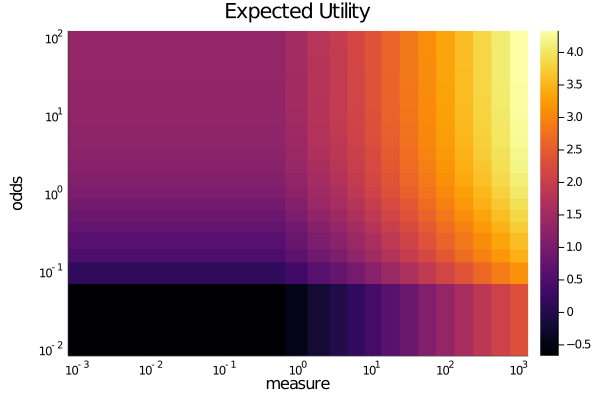

 20.338861 seconds (114.37 M allocations: 8.768 GiB, 8.38% gc time)


In [49]:
@time show_graphs(conflict_parameters)

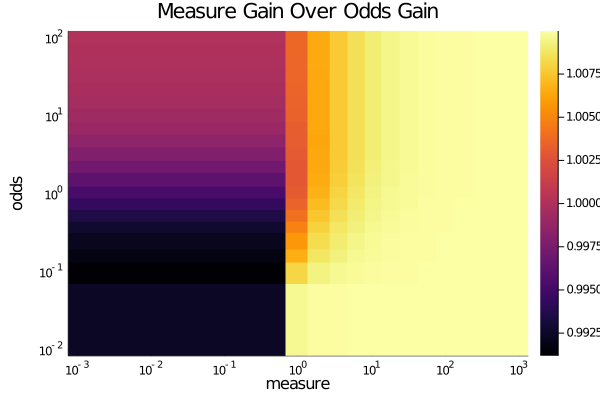

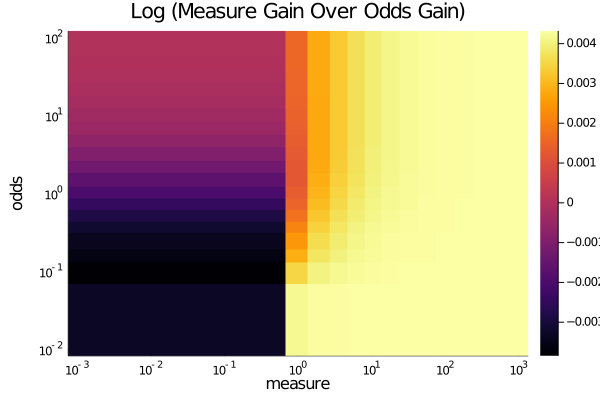

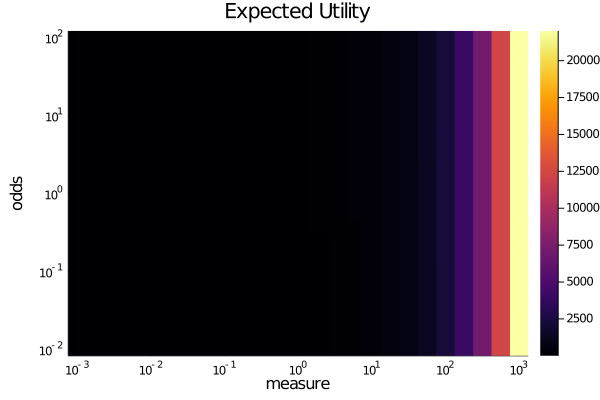

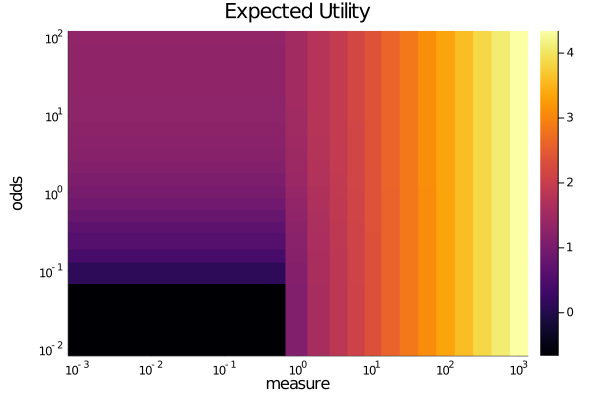

1487.551512 seconds (8.56 G allocations: 646.464 GiB, 8.31% gc time)


In [50]:
@time show_graphs(ksbs_parameters)